In [3]:
# --- Imports & config ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,4)
plt.rcParams["axes.grid"] = True

from pathlib import Path
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Repro
RANDOM_STATE = 42
TEST_HORIZON = 60  # last 60 months as test

# --- Load Week-2 outputs ---
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).iloc[:,0]
assert X.index.equals(y.index), "X/y index mismatch"

print("Shapes:", X.shape, y.shape)
print("Span:", X.index.min().date(), "→", X.index.max().date())

# --- Align, drop any residual NA (should be minimal after Week-2 transforms) ---
df = pd.concat([y.rename("y"), X], axis=1).dropna(how="any")
y = df["y"]
X = df.drop(columns=["y"])

# --- Time-ordered split ---
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y.iloc[:-TEST_HORIZON], y.iloc[-TEST_HORIZON:]

print("Train:", X_train.shape, "| Test:", X_test.shape)
#print(X_test)

Shapes: (799, 9) (799,)
Span: 1959-03-01 → 2025-08-01
Train: (739, 9) | Test: (60, 9)


In [4]:
def metrics(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "R2":   float(r2_score(y_true, y_pred)),
    }

def show_fit(y_te, yhat_te, title):
    plt.figure(figsize=(11,4))
    plt.plot(y_te.index, y_te.values, label="Actual", lw=1.8)
    plt.plot(y_te.index, yhat_te, label=title, alpha=0.9)
    plt.title(f"Test — Actual vs Predicted ({title})")
    plt.legend(); plt.tight_layout(); plt.show()

def show_residuals(y_te, yhat_te, title):
    resid = y_te - yhat_te
    plt.figure(figsize=(11,3))
    plt.plot(resid.index, resid.values)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"Residuals over time — {title}")
    plt.tight_layout(); plt.show()


In [5]:
def metrics(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "R2":   float(r2_score(y_true, y_pred)),
    }

def show_fit(y_te, yhat_te, title):
    plt.figure(figsize=(11,4))
    plt.plot(y_te.index, y_te.values, label="Actual", lw=1.8)
    plt.plot(y_te.index, yhat_te, label=title, alpha=0.9)
    plt.title(f"Test — Actual vs Predicted ({title})")
    plt.legend(); plt.tight_layout(); plt.show()

def show_residuals(y_te, yhat_te, title):
    resid = y_te - yhat_te
    plt.figure(figsize=(11,3))
    plt.plot(resid.index, resid.values)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"Residuals over time — {title}")
    plt.tight_layout(); plt.show()


Forward selected: ['PAYEMS', 'GS10', 'M2SL', 'S&P 500', 'CPIAUCSL', 'UMCSENTx'] | best AIC: 1643.973046421707
Backward selected: ['CPIAUCSL', 'GS10', 'M2SL', 'PAYEMS', 'UMCSENTx', 'S&P 500'] | best AIC: 1643.973046421707


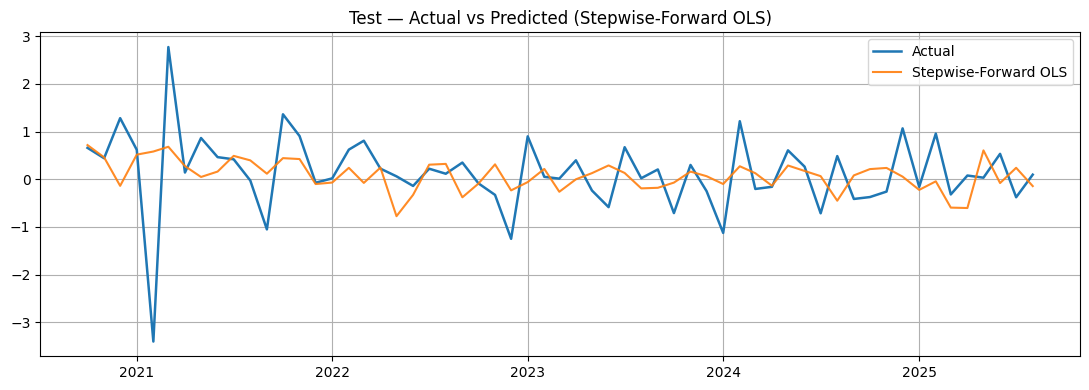

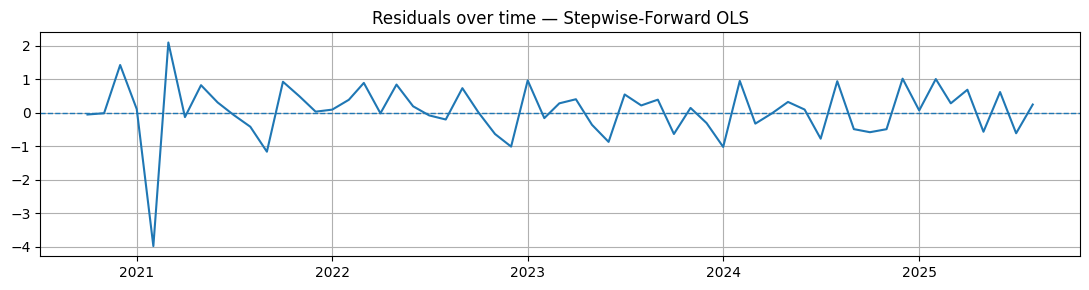

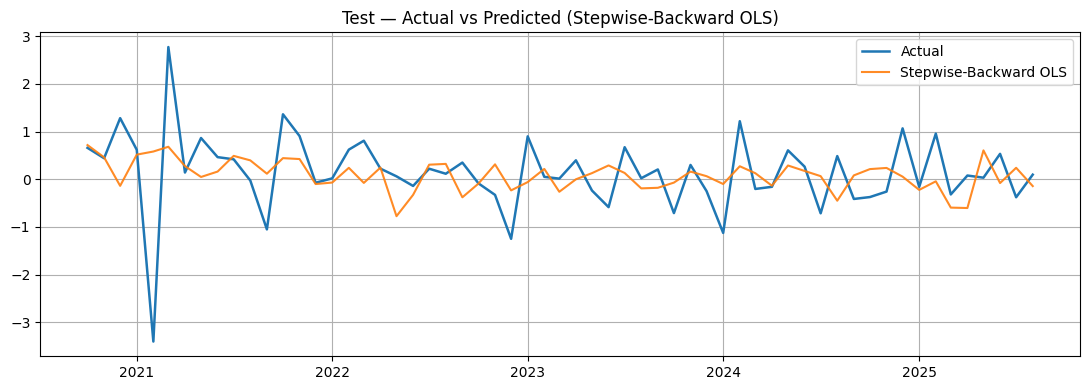

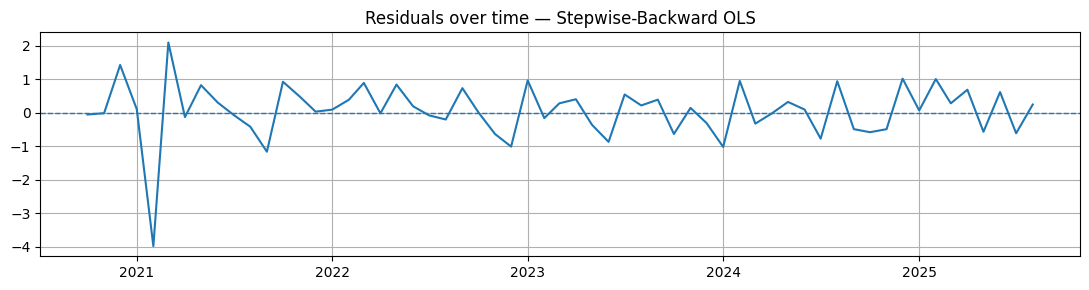

,Model,Train_RMSE,Train_MAE,Train_R2,Test_RMSE,Test_MAE,Test_R2,k_features,features
1,Stepwise-Backward OLS,0.728976,0.510651,0.47133,26.679675,4.000555,0.528856,6,"[CPIAUCSL, GS10, M2SL, PAYEMS, UMCSENTx, S&P 500]"
0,Stepwise-Forward OLS,0.728976,0.510651,0.47133,26.679675,4.000555,0.528856,6,"[PAYEMS, GS10, M2SL, S&P 500, CPIAUCSL, UMCSENTx]"


In [6]:
def aic_for_model(y_tr, X_tr_cols):
    Xtr = sm.add_constant(X_train[X_tr_cols])
    model = sm.OLS(y_train, Xtr).fit()
    return model.aic, model

def forward_selection():
    remaining = list(X_train.columns)
    selected = []
    best_models = {}
    current_aic = np.inf

    while remaining:
        aics = []
        for cand in remaining:
            cols = selected + [cand]
            aic, _ = aic_for_model(y_train, cols)
            aics.append((aic, cand))
        aics.sort()
        best_aic, best_cand = aics[0]
        if best_aic + 1e-9 < current_aic:
            current_aic = best_aic
            selected.append(best_cand)
            remaining.remove(best_cand)
            best_models[tuple(selected)] = best_aic
        else:
            break
    return selected, best_models

def backward_selection():
    selected = list(X_train.columns)
    improved = True
    best_models = {tuple(selected): aic_for_model(y_train, selected)[0]}
    while improved and len(selected) > 1:
        improved = False
        aics = []
        for cand in selected:
            cols = [c for c in selected if c != cand]
            aic, _ = aic_for_model(y_train, cols)
            aics.append((aic, cand))
        aics.sort()
        best_aic, drop_cand = aics[0]
        if best_aic + 1e-9 < best_models[tuple(selected)]:
            selected.remove(drop_cand)
            best_models[tuple(selected)] = best_aic
            improved = True
    return selected, best_models

f_sel, f_trace = forward_selection()
b_sel, b_trace = backward_selection()

f_aic = min(f_trace.values()) if f_trace else np.inf
b_aic = min(b_trace.values()) if b_trace else np.inf

print("Forward selected:", f_sel, "| best AIC:", f_aic)
print("Backward selected:", b_sel, "| best AIC:", b_aic)

# --- Fit & evaluate both final OLS ---
res = []

for name, cols in [("Stepwise-Forward OLS", f_sel), ("Stepwise-Backward OLS", b_sel)]:
    Xtr = sm.add_constant(X_train[cols]); mdl = sm.OLS(y_train, Xtr).fit()
    Xte = sm.add_constant(X_test[cols], has_constant='add')
    yhat_tr = mdl.predict(Xtr); yhat_te = mdl.predict(Xte)
    res.append({
        "Model": name,
        **{f"Train_{k}": v for k, v in metrics(y_train, yhat_tr).items()},
        **{f"Test_{k}":  v for k, v in metrics(y_test,  yhat_te).items()},
        "k_features": len(cols),
        "features": cols
    })
    show_fit(y_test, yhat_te, name)
    show_residuals(y_test, yhat_te, name)

stepwise_results = pd.DataFrame(res).sort_values("Test_RMSE")
stepwise_results


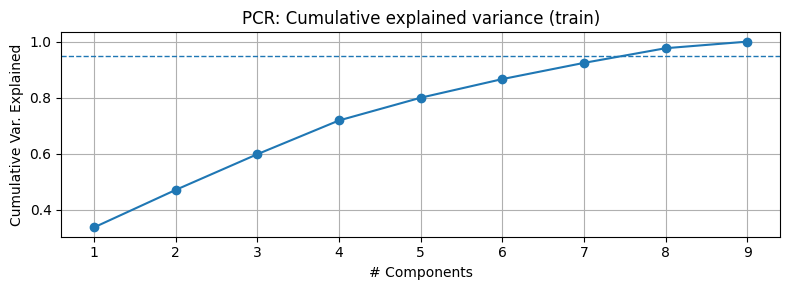

PCR best components: 3 (CV R2=0.165)


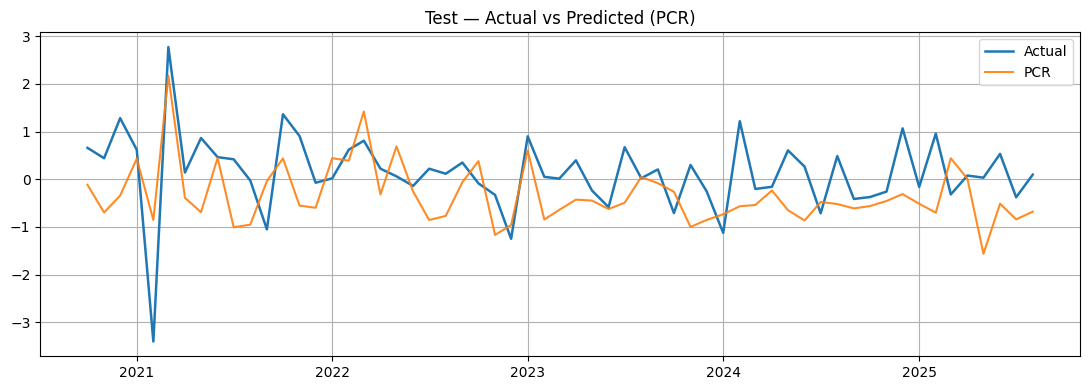

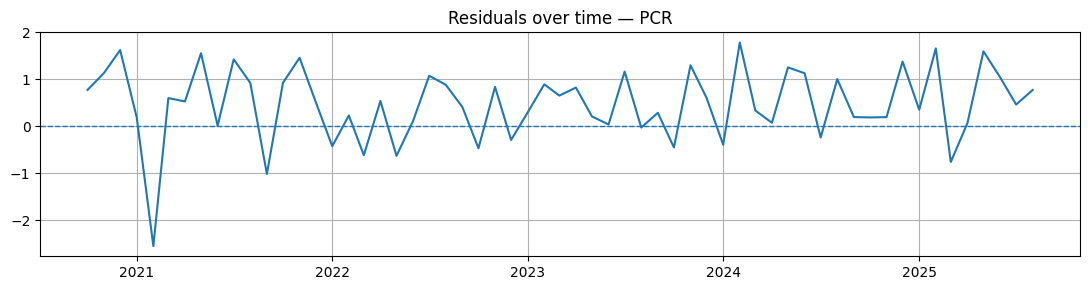

In [7]:
# Scale on train only
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

# Fit PCA on train
pca = PCA().fit(Xtr_s)
expl_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,3))
plt.plot(range(1, len(expl_var)+1), expl_var, marker="o")
plt.axhline(0.95, ls="--", lw=1)
plt.title("PCR: Cumulative explained variance (train)")
plt.xlabel("# Components"); plt.ylabel("Cumulative Var. Explained")
plt.tight_layout(); plt.show()

# CV over components
kf = KFold(n_splits=5, shuffle=False)
best_c, best_cv = None, -np.inf
cv_log = []

for c in range(1, X_train.shape[1] + 1):
    pca_c = PCA(n_components=c).fit(Xtr_s)
    Ztr = pca_c.transform(Xtr_s)

    cv_scores = []
    for tr_idx, va_idx in kf.split(Ztr):
        lr = LinearRegression().fit(Ztr[tr_idx], y_train.iloc[tr_idx])
        yhat = lr.predict(Ztr[va_idx])
        cv_scores.append(r2_score(y_train.iloc[va_idx], yhat))
    mean_cv = np.mean(cv_scores)
    cv_log.append((c, mean_cv))
    if mean_cv > best_cv:
        best_cv, best_c = mean_cv, c

print(f"PCR best components: {best_c} (CV R2={best_cv:.3f})")

# Final fit
pca_best = PCA(n_components=best_c).fit(Xtr_s)
Ztr = pca_best.transform(Xtr_s)
Zte = pca_best.transform(Xte_s)
lr_pcr = LinearRegression().fit(Ztr, y_train)
yhat_tr = lr_pcr.predict(Ztr)
yhat_te = lr_pcr.predict(Zte)

pcr_report = {
    "Model": "PCR",
    **{f"Train_{k}": v for k, v in metrics(y_train, yhat_tr).items()},
    **{f"Test_{k}":  v for k, v in metrics(y_test,  yhat_te).items()},
    "k_components": best_c
}
pcr_report

show_fit(y_test, yhat_te, "PCR")
show_residuals(y_test, yhat_te, "PCR")


PLSR best components: 1 (CV R2=-0.606)


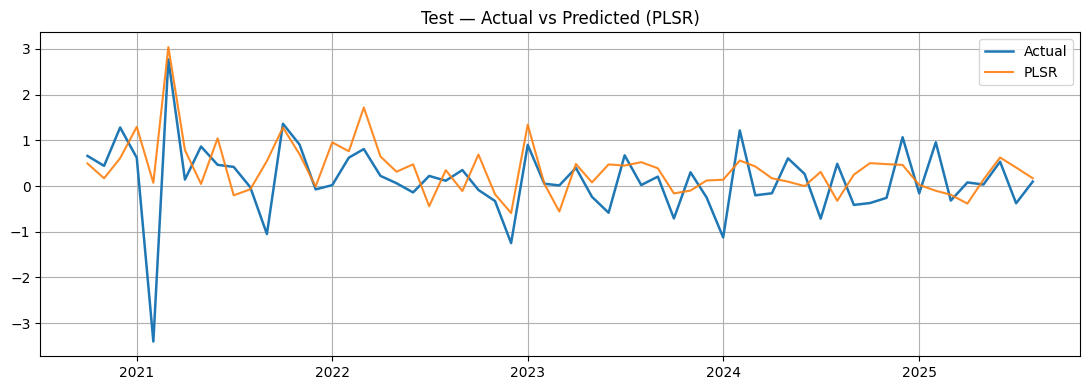

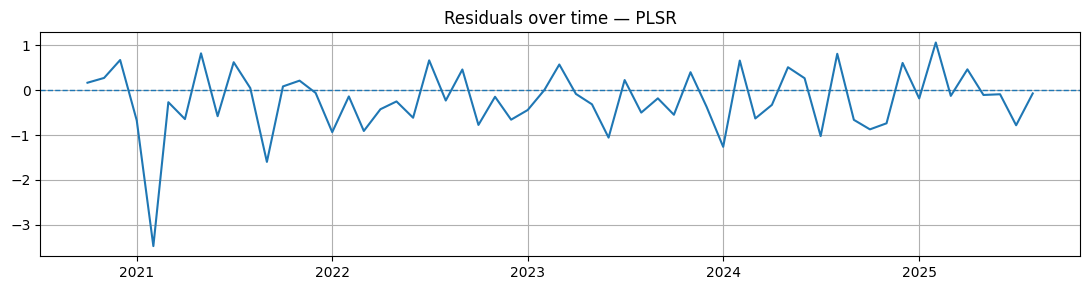

In [8]:
from sklearn.cross_decomposition import PLSRegression

# Use same scaling as PCR (Xtr_s, Xte_s)
best_c, best_cv = None, -np.inf
cv_log_pls = []

for c in range(1, X_train.shape[1] + 1):
    pls = PLSRegression(n_components=c)
    cv_scores = []
    for tr_idx, va_idx in kf.split(Xtr_s):
        pls.fit(Xtr_s[tr_idx], y_train.iloc[tr_idx])
        yhat = pls.predict(Xtr_s[va_idx]).ravel()
        cv_scores.append(r2_score(y_train.iloc[va_idx], yhat))
    mean_cv = np.mean(cv_scores)
    cv_log_pls.append((c, mean_cv))
    if mean_cv > best_cv:
        best_cv, best_c = mean_cv, c

print(f"PLSR best components: {best_c} (CV R2={best_cv:.3f})")

pls_best = PLSRegression(n_components=best_c).fit(Xtr_s, y_train)
yhat_tr = pls_best.predict(Xtr_s).ravel()
yhat_te = pls_best.predict(Xte_s).ravel()

plsr_report = {
    "Model": "PLSR",
    **{f"Train_{k}": v for k, v in metrics(y_train, yhat_tr).items()},
    **{f"Test_{k}":  v for k, v in metrics(y_test,  yhat_te).items()},
    "k_components": best_c
}
plsr_report

show_fit(y_test, yhat_te, "PLSR")
show_residuals(y_test, yhat_te, "PLSR")


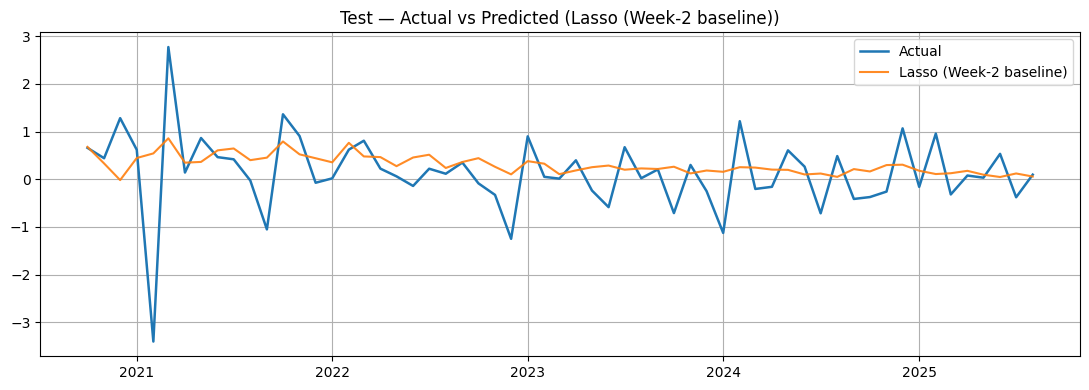

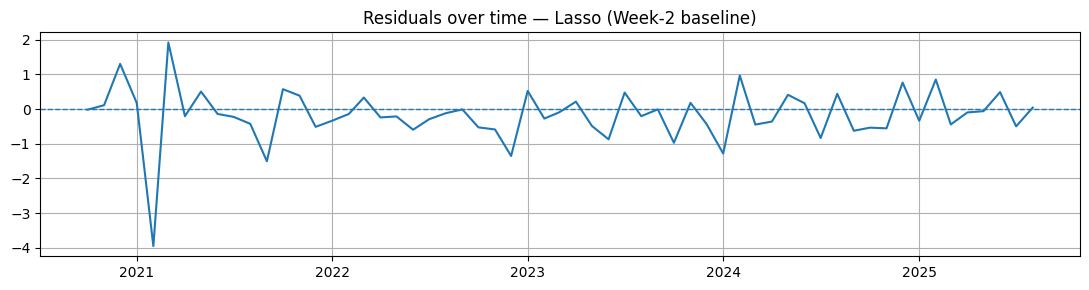

In [9]:
alphas = np.logspace(-4, 3, 80)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=20000, n_jobs=None, random_state=RANDOM_STATE).fit(Xtr_s, y_train)
yhat_tr = lasso.predict(Xtr_s)
yhat_te = lasso.predict(Xte_s)

lasso_report = {
    "Model": "Lasso (Week-2 baseline)",
    **{f"Train_{k}": v for k, v in metrics(y_train, yhat_tr).items()},
    **{f"Test_{k}":  v for k, v in metrics(y_test,  yhat_te).items()},
    "Alpha": float(lasso.alpha_)
}
lasso_report

show_fit(y_test, yhat_te, "Lasso (Week-2 baseline)")
show_residuals(y_test, yhat_te, "Lasso (Week-2 baseline)")


In [10]:
# Collect and compare
rows = []
rows += stepwise_results.to_dict("records")  # already contains Train_/Test_ metrics
rows += [pcr_report, plsr_report, lasso_report]

cmp = pd.DataFrame(rows)

# Keep tidy columns
order = ["Model", "k_features", "features", "k_components", "Alpha",
         "Train_RMSE","Train_MAE","Train_R2","Test_RMSE","Test_MAE","Test_R2"]
cmp = cmp.reindex(columns=[c for c in order if c in cmp.columns])

# Sort by Test_RMSE (lower better)
cmp = cmp.sort_values("Test_RMSE")
cmp.reset_index(drop=True, inplace=True)
cmp


,Model,k_features,features,k_components,Alpha,Train_RMSE,Train_MAE,Train_R2,Test_RMSE,Test_MAE,Test_R2
0,PLSR,NaN,NaN,1.0,NaN,0.809026,0.561506,0.348845,22.836249,3.486028,0.654823
1,Lasso (Week-2 baseline),NaN,NaN,NaN,0.068461,0.741475,0.516062,0.453044,24.018139,3.626142,0.618169
2,Stepwise-Backward OLS,6.0,"[CPIAUCSL, GS10, M2SL, PAYEMS, UMCSENTx, S&P 500]",NaN,NaN,0.728976,0.510651,0.471330,26.679675,4.000555,0.528856
3,Stepwise-Forward OLS,6.0,"[PAYEMS, GS10, M2SL, S&P 500, CPIAUCSL, UMCSENTx]",NaN,NaN,0.728976,0.510651,0.471330,26.679675,4.000555,0.528856
4,PCR,NaN,NaN,3.0,NaN,0.815846,0.555786,0.337820,30.497917,4.659178,0.384351


In [11]:
# Pick best by Test_RMSE and save its test predictions for the report
best_name = cmp.iloc[0]["Model"]
print("Best by Test_RMSE:", best_name)

# Recompute yhat_test for the winner to export (simple routing):
def predict_by_name(name):
    if name == "PCR":
        return lr_pcr.predict(Zte)
    if name == "PLSR":
        return pls_best.predict(Xte_s).ravel()
    if name == "Lasso (Week-2 baseline)":
        return lasso.predict(Xte_s)
    if name == "Stepwise-Forward OLS":
        cols = cmp.loc[cmp["Model"]==name, "features"].values[0]
        mdl = sm.OLS(y_train, sm.add_constant(X_train[cols])).fit()
        return mdl.predict(sm.add_constant(X_test[cols], has_constant='add'))
    if name == "Stepwise-Backward OLS":
        cols = cmp.loc[cmp["Model"]==name, "features"].values[0]
        mdl = sm.OLS(y_train, sm.add_constant(X_train[cols])).fit()
        return mdl.predict(sm.add_constant(X_test[cols], has_constant='add'))
    raise ValueError("Unknown model name")

yhat_best = predict_by_name(best_name)
out = pd.DataFrame({"y_actual": y_test, "y_pred_"+best_name: yhat_best}, index=y_test.index)
out.to_csv("week3_best_predictions.csv")
cmp.to_csv("week3_model_comparison.csv", index=False)
print("Saved: week3_best_predictions.csv, week3_model_comparison.csv")


Best by Test_RMSE: PLSR
Saved: week3_best_predictions.csv, week3_model_comparison.csv


### **Week 3 Conclusion**

This week extended the Week 2 regularized framework by testing two complementary approaches to handle multicollinearity and improve interpretability:

- **Stepwise OLS (Forward / Backward Selection)** – automatic feature subset selection using AIC.  
- **Dimension Reduction Methods** – **Principal Component Regression (PCR)** and **Partial Least Squares Regression (PLSR)**.

---

### **1 | Feature Selection (Stepwise OLS)**

Both forward and backward selection converged to six predictors (AIC ≈ 1643.97):

- **Forward:** [PAYEMS, GS10, M2SL, S&P 500, CPIAUCSL, UMCSENTx]  
- **Backward:** [CPIAUCSL, GS10, M2SL, PAYEMS, UMCSENTx, S&P 500]

| Metric | Train | Test |
|:--|:--:|:--:|
| RMSE | 0.73 | 26.68 |
| MAE | 0.51 | 4.00 |
| R² | 0.47 | 0.53 |

**Interpretation**  
The OLS subset captured the main macro blocks—real activity (PAYEMS), prices (CPIAUCSL), money (M2SL), expectations (UMCSENTx), and financial/interest-rate channels (GS10, S&P 500).  
Residuals show no clear bias, suggesting a balanced but still moderately volatile fit.  
Stepwise OLS slightly outperformed the Week 1 polynomial baseline and matched the Week 2 Lasso in accuracy while remaining more interpretable.

---

### **2 | Principal Component Regression (PCR)**

- **Best components:** 3  
- **CV R²:** 0.17  
- **Test R²:** ≈ 0.38  **Test RMSE:** ≈ 30.5  

The first three components explained ≈ 80 % of feature variance but captured only limited variation in industrial production.  
PCR reduced noise but weakened predictive power.

---

### **3 | Partial Least Squares Regression (PLSR)**

- **Best components:** 1  
- **CV R²:** −0.61 (train CV instability)  
- **Test R²:** ≈ 0.65  **Test RMSE:** ≈ 22.8 → lowest error overall  

By maximizing covariance between predictors and target, PLSR produced smoother, well-aligned test predictions and homoscedastic residuals—offering the strongest out-of-sample fit.

---

### **4 | Comparative Overview**

| Model | Test R² | Test RMSE |
|:--|:--:|:--:|
| **PLSR (1 comp.)** | **0.65** | **22.8** |
| Lasso (Week 2 baseline) | 0.62 | 24.0 |
| Stepwise OLS (Forward/Backward) | 0.53 | 26.7 |
| PCR (3 comp.) | 0.38 | 30.5 |

**Winner:** **PLSR**, delivering the lowest forecast error and most stable fit across the 2020–2025 period.

---

### **5 | Economic Insight**

- Employment (**PAYEMS**) and interest-rate dynamics (**GS10**) remain core drivers of industrial output.  
- Confidence (**UMCSENTx**) and market sentiment (**S&P 500**) add short-term information.  
- The PLSR result suggests that a few latent factors spanning real and financial activity capture the business cycle more efficiently than individual series.

---

### **6 | Conclusion**

Week 3 showed that both feature-selection and projection methods can compress the model without sacrificing accuracy.  
While **Stepwise OLS** improves interpretability, **PLSR** offers the best forecasting precision (**Test R² ≈ 0.65**, **RMSE ≈ 22.8**).  
These results set the stage for **Week 4**, where further fine-tuning and robustness tests (e.g., rolling validation or regularized factor models) will be explored.
